## Concordances of DL-parenchymal vs. ground-truth attenuation. 

Figure 4. Concordances of DL-parenchymal vs. ground-truth attenuation. DL-parenchymal attenuation was compared to ground-truth attenuations on partitioned datasets (development set: n=399, internal test set: n=80, external test set: n=535). The scatter plot shows the p value, slope, and Spearman correlation coefficient. The agreement was further assessed using Bland-Altman analysis, with liver attenuations in Hounsfield units (HU) on the x-axis. The bold line represents the actual mean difference (error), and the other two dotted lines show 95% limits of agreements.  

This script derives the concordance of DL-parenchymal attenuation on the internal and external data: 4.b and 4.c

In [1]:
import pandas as pd

csv_path = '../csv/stats_csv_curated/Liver_attenuation_AI_vs_manual_ROI_n_615.csv'

df_init = pd.read_csv( csv_path)
df_init = df_init[df_init['partition'] == 'External_test']  # dataframe retained within external tests
# df_init = df_init[df_init['partition'] != 'External_test'] # dataframe retained within internal tests

print(df_init.shape)
df_init.head()

(535, 8)


,partition,data_set,CT_id,nnunet_to_roi,nnunet_to_3d,nnunet_to_2d,manual_select_roi,manual_hs
0,External_test,covid_china,covid_0700,50.85702,52.90228,51.26072,54.7063,0
1,External_test,covid_china,covid_0701,55.18537,57.69963,56.67069,59.8407,0
2,External_test,covid_china,covid_0702,44.04323,48.89912,46.94244,44.0310,0
3,External_test,covid_china,covid_0703,36.60765,39.93153,39.90219,42.0273,0
4,External_test,covid_china,covid_0704,56.26933,55.38742,55.31121,56.4772,0


In [2]:
# Compute the mean absolute error, P value, and spearman correlation between AI-ROI and manual-ROI selection
from scipy import stats
import numpy as np
density_col = ['manual_select_roi','nnunet_to_roi', 'nnunet_to_3d', 'nnunet_to_2d']

density_gd = df_init[density_col[0]]
mean = round(np.mean(density_gd),2)
print('Liver attenuation of ', density_col[0], 'len:',len(density_gd))
std = round(np.std(density_gd),2)
print('np.mean',mean, 'np.std',std,'\n')

for i in range(1,len(density_col)):
    density_compare = df_init[density_col[i]]
    print('Liver attenuation of ',density_col[i], ' length:',len(density_compare))
    mean = round(np.mean(density_compare),2)
    std = round(np.std(density_compare),2)
    print('np.mean',mean, 'np.std',std)
    mse = np.sum(abs(density_compare - density_gd)) / len(density_compare)
    print('mse',round(mse,3), '\n')
    
    sp_cor = stats.spearmanr(density_compare,density_gd)
    print('spearman correlation', sp_cor)
    
    ks_s, ks_p = stats.ks_2samp(density_compare,density_gd)
    if ks_p >0.05:
        print(density_col[i], 'ks_p_value',ks_p,' NS NS NS ')
    if ks_p <=0.05:
        print(density_col[i], 'ks_p_value',ks_p,' Significant')
    print('\n\n\n\n')

Liver attenuation of  manual_select_roi len: 535
np.mean 52.32 np.std 11.38 

Liver attenuation of  nnunet_to_roi  length: 535
np.mean 51.38 np.std 11.32
mse 2.432 

spearman correlation SpearmanrResult(correlation=0.9485880940944352, pvalue=1.862403512302503e-268)
nnunet_to_roi ks_p_value 0.5037924430548701  NS NS NS 





Liver attenuation of  nnunet_to_3d  length: 535
np.mean 50.8 np.std 10.22
mse 2.517 

spearman correlation SpearmanrResult(correlation=0.9616244082129685, pvalue=1.542081733436399e-301)
nnunet_to_3d ks_p_value 0.012723510345422684  Significant





Liver attenuation of  nnunet_to_2d  length: 535
np.mean 51.15 np.std 10.0
mse 2.616 

spearman correlation SpearmanrResult(correlation=0.9488298145742134, pvalue=5.481141030124024e-269)
nnunet_to_2d ks_p_value 0.022442678808725133  Significant







In [3]:
# Compute the slope of scattor plot

from sklearn import linear_model

col = ['manual_select_roi','nnunet_to_roi'] #'density_of_roi_seg_unet_nlst'

density_gd = df_init[col[0]]
density_seg_roi = df_init[col[1]]

model = linear_model.LinearRegression()
x_new = np.array(density_gd).reshape(-1, 1)
y_new = np.array(density_seg_roi).reshape(-1, 1)

model.fit(x_new, y_new )

print("slope w：", model.coef_)
print("interception b：", model.intercept_)

slope w： [[0.95586895]]
interception b： [1.37162005]


<Figure size 1000x1000 with 0 Axes>

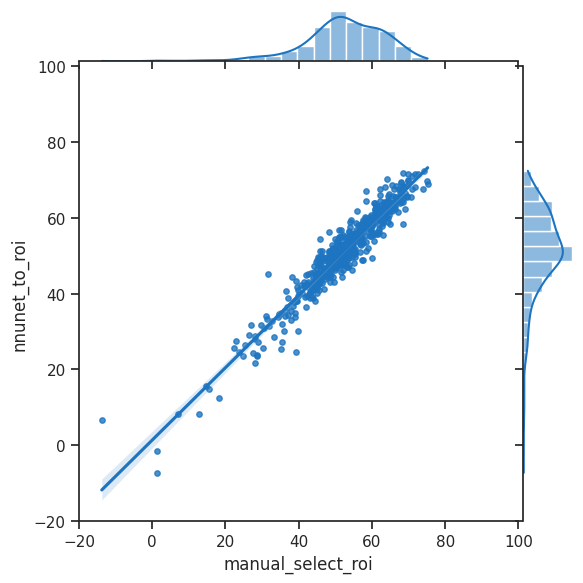

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(10, 10)}) 
sns.set_style("ticks")

sns.despine()

min_lim, max_lim = -20, 100

ax = sns.jointplot(data=df_init, x=col[0], y=col[1] , color = '#1d74c0ff',
              marginal_kws = dict(bins= 20), space = 0.1,ratio = 8
              , xlim=[min_lim, max_lim], ylim=[min_lim, max_lim]
              , kind = 'reg'
              , scatter_kws={'s': 15}
             )
ax.fig.set_size_inches(6,6)
plt.savefig( 'figures_in_png/joint_plot_' + col[0] + '_' +col[1] +'.png', dpi = 500)


In [5]:
[colgd, colai ]  = ['manual_select_roi','nnunet_to_roi']

x_ax = np.array(df_init[colgd])
y_ax = (np.array(df_init[colai]) - np.array(df_init[colgd])) 

std196 = 1.96*np.std((y_ax))
print('Std of difference ',np.std((y_ax)))
print('1.96std of abs difference ',std196)

mean_dif = np.mean((y_ax))
print('Mean of  difference', mean_dif)
print('Mean +1.96std', mean_dif+ std196)
print('Mean -1.96std', mean_dif- std196)

outliers = []
for y_value in y_ax:
    if y_value < mean_dif- std196 or y_value > mean_dif + std196:
        outliers.append(y_value)
print('Len(outliers)',len(outliers), 'Len of all test images',len(y_ax),' = %', len(outliers)/ len(y_ax) *100)

Std of difference  3.1759819263496816
1.96std of abs difference  6.2249245756453755
Mean of  difference -0.9373769158878507
Mean +1.96std 5.287547659757525
Mean -1.96std -7.162301491533226
Len(outliers) 25 Len of all test images 535  = % 4.672897196261682


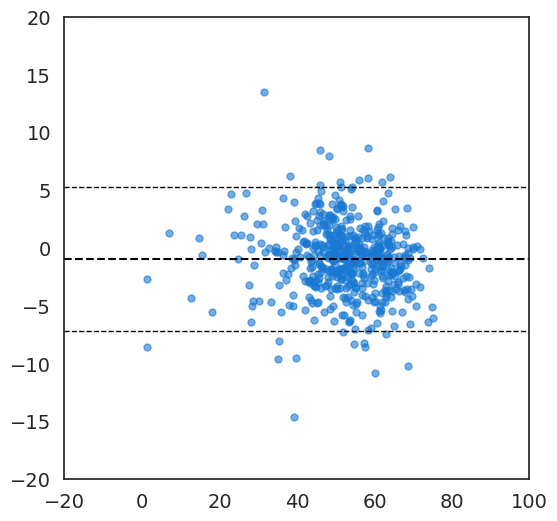

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

min_x, max_x = -20, 100
min_y, max_y = -20,20

ax.plot(x_ax, y_ax, '.', markersize= 10, color='#1878d3ff', alpha = 0.6       )

ax.plot([min_x, max_x], [mean_dif, mean_dif], '--', color='black', linewidth=1.5)
ax.plot([min_x, max_x], [mean_dif+ std196, mean_dif +  std196], '--', color='black', linewidth=1)
ax.plot([min_x, max_x], [mean_dif - std196, mean_dif -  std196], '--', color='black', linewidth= 1)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

ax.tick_params(axis='x', which='both', bottom=False, labelbottom=True, labelsize=14)
ax.tick_params(axis='y', which='both', left=False, labelleft=True, labelsize=14)

plt.savefig( 'figures_in_png/Mean_dif_' + colgd +'.png', dpi = 500)
